In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt

from ipynb.fs.full.Functions import generate_asset_payoff, generate_trader_valuation, generate_dealer_action, generate_q_matrix

# Variable Setting

This is where we can set the variables of our economic environment. We can play around with these variables.

In [2]:
# Asset parameters
payoff_high = 4
prob_high = 0.5
payoff_low = 0
prob_low = 0.5
expected_payoff = payoff_high*prob_high + payoff_low*prob_low

# Dealer parameter
no_of_dealer = 1
lowest_ask_price = 1
highest_ask_price = 15
possible_ask_price = np.arange(lowest_ask_price, highest_ask_price+1, 1)

# Trader parameters
private_valuation_mean = 0
private_valuation_sd = 5

# Learning parameters
alpha = 0.01
beta = 0.0008
lower_q = 3
upper_q = 6

# Number of Experiments and Episode
K = 1000
T = 200000

# Import Functions
We have pre-written functions in the file "Functions.ipynb". We will be importing these functions and testing them.

We first try the "generate_asset_payoff" function with our above parameters. This should generate an array of 0 or 4 values each with a probability of 1/2 and the total length of the array is T episodes.

In [3]:
generate_asset_payoff(prob_low, prob_high, payoff_low, payoff_high,T,1)

array([0., 4., 0., ..., 0., 4., 4.])

With the "generate_trader_valuation" function, this will generate an array of values of informed traders' valuation of the asset, each trader will have their own private valuation normally distributed with self-defined mean and standard deviation.

In [4]:
generate_trader_valuation(generate_asset_payoff(prob_low, prob_high, payoff_low, payoff_high,T,1), private_valuation_mean,private_valuation_sd,1)

array([ 8.12172682,  0.94121793, -2.64085876, ...,  4.1681861 ,
        4.0186687 ,  7.8609922 ])

With the "generate_dealer_action" function, we generate an array of either "explore" or "exploit" with the probability of "explore" decreasing over the array. The probability of "explore" at episode t is defined by the equation exp(-beta*t). With 200,000 episodes, we expect an average of 1249.5 "explore" actions.

In [5]:
print(generate_dealer_action(beta,T,1))
np.unique(generate_dealer_action(beta,T,1), return_counts = True)

['explore' 'explore' 'explore' ... 'exploit' 'exploit' 'exploit']


(array(['exploit', 'explore'], dtype='<U21'), array([198777,   1223]))

With the "generate_q_matrix" function, we generate a 1-dimensional array with values randomly sampled from a uniform distribution defined by U(lower_q, upper_q) and the total length of the array is the possible ask price the dealer can choose from. This is the initial Q-matrix of the dealer.

In [6]:
generate_q_matrix(lower_q, upper_q, len(possible_ask_price), no_of_dealer,1)

,dealer_1
0,4.251066
1,5.160973
2,3.000343
3,3.906998
4,3.440268
5,3.277016
6,3.558781
7,4.036682
8,4.190302
9,4.616450


# Monopoly Situation

Here, we run the simulation in the monopoly market maker situation, where there is only one dealer in the market.

In [7]:
greedy_price_df = pd.DataFrame(np.arange(1,T+1,1), columns = ['episodes'])

# k iterates for each experiment, we will use k as the random seed for each experiment as well
for k in np.arange(1,K+1,1):

    # Track Process
    if k%100 == 0: print(str(k/K*100) + "%")

    # This array saves the historical greedy prices for each experiment
    historical_greedy_price = np.array([])

    # Initate experiment with initial variables (Asset Payoff, Trader Valuation, Dealer Action, Q-Matrix)
    asset_payoff = generate_asset_payoff(prob_low, prob_high, payoff_low, payoff_high,T,k)
    trader_valuation = generate_trader_valuation(generate_asset_payoff(prob_low, prob_high, payoff_low, payoff_high,T,k), private_valuation_mean,private_valuation_sd,k)
    dealer_action = generate_dealer_action(beta,T,k)
    Q_matrix = generate_q_matrix(lower_q, upper_q, len(possible_ask_price), no_of_dealer,k)

    # Set random seed for ask_price randomisation during "explore", we iterate this over every experiment to make sure different experiments are selecting different "explore" ask prices
    random.seed(k)

    # Loop over each episode
    for t in np.arange(0,T,1):
        
        # Dealer chooses to explore or exploit
        if dealer_action[t] == "explore":
            # If explore, ask_price is random integer from 1 to 15, since we have set seed=k above, this makes sure that ask_prices are taken at random differently in each experiment
            ask_price = random.choice(possible_ask_price)

        if dealer_action[t] == "exploit":
            # If exploit, ask_price is the action with the highest expected payoff from Q_matrix
            ask_price = np.argmax(Q_matrix.iloc[:,0])+1

            # Use an array to save historical ask prices and stop if greedy price didn't change for 10000 episodes
            historical_greedy_price = np.append(historical_greedy_price, ask_price)
            if len(historical_greedy_price) > 10000 and np.std(historical_greedy_price[-10000:]) == 0:
                break       

        # Informed trader now chooses whether to trade in this episode according to the ask_price
        # Case 1) Trader chooses to trade
        if trader_valuation[t] >= ask_price:
            # We update the Q-matrix of the dealer based on the profit made when a trade occurred in this episode
            Q_matrix.iloc[ask_price-1,0] = alpha*(ask_price-asset_payoff[t]) + (1-alpha)*Q_matrix.iloc[ask_price-1,0]

        # Case 2) Trader chooses not to trade
        if trader_valuation[t] < ask_price:
            # Otherwise, profit is 0 and the Q-matrix of the dealer is updated accordingly
            Q_matrix.iloc[ask_price-1,0] = (1-alpha)*Q_matrix.iloc[ask_price-1,0]
    
    # Save the historical greedy price for this experiment in the dataframe
    greedy_price_df = pd.concat([greedy_price_df, pd.DataFrame(historical_greedy_price, columns = ['experiment' + str(k)])], axis = 1)

greedy_price_df.set_index("episodes", inplace = True)

10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


In [7]:
#greedy_price_df.to_csv("monopoly_dealer_price.csv")
greedy_price_df = pd.read_csv("monopoly_dealer_price.csv")
greedy_price_df.set_index("episodes", inplace = True)

# Results

We will be analyzing the results here with graphs.

We first look at how the average greedy price changes over episodes for the market marker. This gives us the idea of how the market maker learns from the environment.

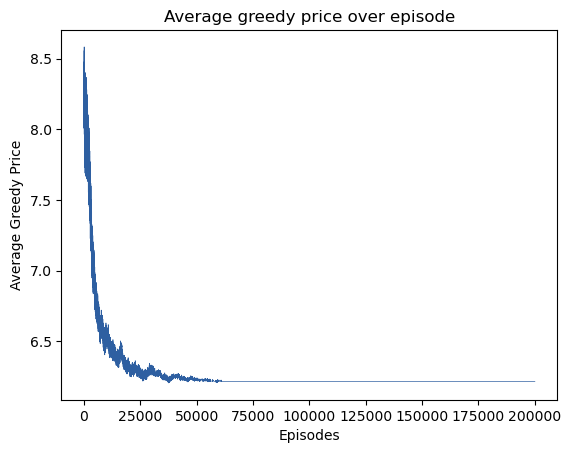

In [9]:
plt.title("Average greedy price over episode")
plt.plot(greedy_price_df.ffill().mean(axis = 1), color = "#2e5fa1", linewidth = 0.5)
plt.xlabel("Episodes")
plt.ylabel("Average Greedy Price")
plt.savefig("Monopoly average greedy price over time.png")
plt.show()

We are also interested in the final greedy price market makers arrives in.

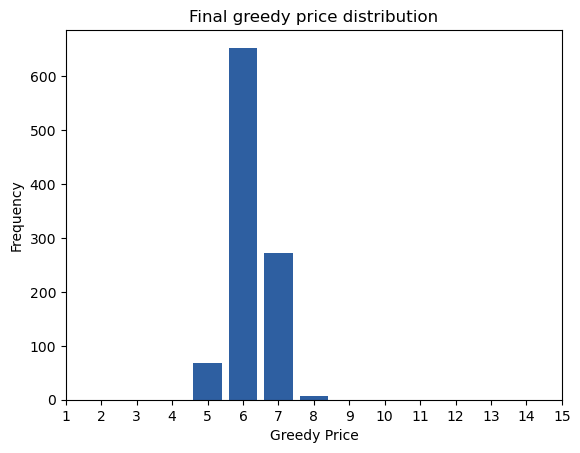

In [10]:
greedy_prices, greedy_prices_freq = np.unique(greedy_price_df.ffill(axis = 0).iloc[-1,:], return_counts = True)

plt.title("Final greedy price distribution")
plt.bar(greedy_prices, greedy_prices_freq, color = "#2e5fa1")
plt.xlabel("Greedy Price")
plt.ylabel("Frequency")
plt.xticks(np.arange(1,16,1))
plt.savefig("Monopoly final greedy price distribution.png")
plt.show()